In [1]:
%matplotlib inline

import sys

sys.path.append('../')

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import numpy as np
import itertools

from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

#from utils.generative import Dirichlet
from utils.generative import Dirichlet_skl as Dirichlet
from utils.generative import Gaussian
from utils.generative import MixtureDistribution
 
from utils.visualisations import plot_confusion_matrix
from utils.visualisations import plot_weight_matrix
from utils.visualisations import plot_individual_pdfs

from utils.barycentric import draw_func_contours
from utils.barycentric import get_converging_lines
from utils.barycentric import plot_converging_lines_pvalues
from utils.barycentric import draw_tri_samples

from utils import barycentric

from dirichlet import DirichletCalibrator

def perfect_calibration(x, mg, sym_class_1=0, sym_class_2=2, sym_axis=1):
    nonsym_class = (0+1+2) - (sym_class_1+sym_class_2)
    d1 = mg.distributions[sym_class_1]
    d2 = mg.distributions[sym_class_2]
    d3 = mg.distributions[nonsym_class]
    a = sym_axis
    assert d1.mean[a]==d2.mean[a]
    assert d1.cov[a,a]==d2.cov[a,a]
    mirror_location = (d3.mean[a]*d1.cov[a,a]-d1.mean[a]*d3.cov[a,a]) / (d1.cov[a,a]-d3.cov[a,a])
    x_mirror = x.copy()
    x_mirror[:,a] = 2*mirror_location - x_mirror[:,a]
    qq = mg.pdf(x)/(mg.pdf(x)+mg.pdf(x_mirror))
    qqx = qq.reshape(-1,1)
    qqxm = 1-qqx
    qc = qqx * mg.posterior(x) + qqxm * mg.posterior(x_mirror)
    return qc

In [2]:
plt.rcParams['figure.figsize'] = (16, 5)

# Same number of samples will be generated for training and for test
n_samples = 100000

# Square grid precision
grid_levels = 200

# Barycentric grid precision
bc_grid_levels = 50
bc_grid_subdiv = 5

eps = np.finfo(np.float).tiny

colors = ['red', 'green', 'blue']

# 1. Mixture of Multivariate Gaussian distribution

alphas = 
[[9 6 6]
 [2 3 1]
 [3 6 6]]
prior = 0.33, Distribution = Dirichlet(alphas = [9,6,6])
prior = 0.33, Distribution = Dirichlet(alphas = [2,3,1])
prior = 0.33, Distribution = Dirichlet(alphas = [3,6,6])


means = 
[[ 0.43452381  0.        ]
 [ 1.          1.5       ]
 [-0.78333333  0.        ]]

covariances = 
[[[0.29883497 0.18132296]
  [0.18132296 0.36264591]]

 [[2.28986813 1.64493407]
  [1.64493407 2.03986813]]

 [[0.57625702 0.18132296]
  [0.18132296 0.36264591]]]

prior = 0.33, Distribution = Gaussian(mean = [0.43452381 0.        ], cov = [[0.29883497 0.18132296]
 [0.18132296 0.36264591]])
prior = 0.33, Distribution = Gaussian(mean = [1.  1.5], cov = [[2.28986813 1.64493407]
 [1.64493407 2.03986813]])
prior = 0.33, Distribution = Gaussian(mean = [-0.78333333  0.        ], cov = [[0.57625702 0.18132296]
 [0.18132296 0.36264591]])



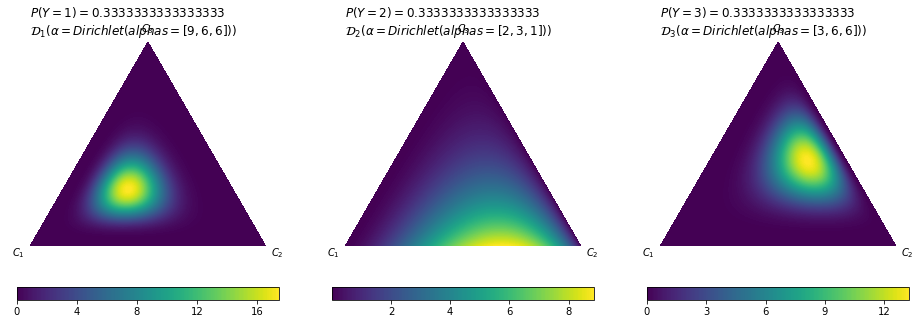

In [3]:
np.random.seed(42)
prior = [1/3, 1/3, 1/3]

# Toy examples (A, B and C)
## A. a, b, c, parametrization approach
## B. Full specification
## C. New logit-normal approach
TOY_EXAMPLE = 'C'

# Ignore class 3 and mirror class 1 instead
MIRROR_C1_TO_C3 = False

if TOY_EXAMPLE == 'A':
    #a = 1; b = 0.9; c = 0.5 # Perfect calibration and Irreducible are equal 
    a = 1
    b = 0.9
    c = 0.5
    means = np.array([[-a, +a], [0, 0], [+a, +a]])

    covariances = np.array([[[+b, -c], [-c, +b]],
                            [[ 1,  0], [ 0,  1]],
                            [[+b, +c], [+c, +b]]])
elif TOY_EXAMPLE == 'B':
    means = np.array([[1, 0], [-1, 0], [-1, -1]])
    means = np.array([[-1, 0], [0, 0], [1, 0]])


    covariances = np.array([[[6, 2], [2, 3]],
                            [[2, 1], [1, 2]],
                            [[2, 2], [2, 3]]])
    
    #means = np.array([[ 1,  0.], [-2,  0.], [-1, -1.]])
    #covariances = np.array(
    #    [[[127.70067636, 101.43329915],
    #      [101.43329915, 202.8665983 ]],
#
    #     [[502.96565649, 101.43329915],
    #      [101.43329915, 202.8665983 ]],
#
#         [[127.70067636, 26.26737721],
#          [ 26.26737721, 127.70067636]]])
    
    
elif TOY_EXAMPLE == 'C':
    from scipy.special import digamma
    from scipy.special import polygamma
    from functools import partial
    trigamma = partial(polygamma, n=1) 

    # Some tricks with the alpha values
    # - When keeping the 2 last alphas equal, the new Gaussian will have mean X[1] = 0
    #   and their Dirichlet will be in the simplex diagonal joining C1 left corner to
    #   Center right between C2 and C3
    # - In this case, the order of the Dirichlets from left to right will be inverted 
    #   in the Gaussians that will be from right to left.
    #
    #alphas = np.array(((2, 4, 4), (1, 1, 2), (4, 2, 2)))*0.05
    alphas = np.array(((9, 6, 6), (2, 3, 1), (3, 6, 6)))
    #alphas = np.array(((2, 4, 4), (4, 4, 4), (8, 4, 4)))
    means = np.zeros((3,2))
    covariances = np.zeros((3, 2, 2))
    for g_i in range(3):
        for i in range(2):
            means[g_i, i] = digamma(alphas[g_i, i]) - digamma(alphas[g_i, -1])
            for j in range(2):
                if i == j:
                    covariances[g_i, i, j] = trigamma(x=alphas[g_i, i]) + trigamma(x=alphas[g_i, -1])
                else:
                    covariances[g_i, i, j] = trigamma(x=alphas[g_i, -1])
               
    print('alphas = \n{}'.format(alphas))
    md = MixtureDistribution(priors=prior, distributions=[Dirichlet(alpha) for alpha in alphas])
    print(md)
        
    barycentric.plot_individual_pdfs(md)
    
    # Rounding for nicer values
    #means = np.round(means, decimals=1)
    #covariances = np.round(covariances, decimals=1) 


if MIRROR_C1_TO_C3:
    means[2] = -means[0]
    covariances[2] = covariances[0]

print('\nmeans = \n{}'.format(means))
print('\ncovariances = \n{}'.format(covariances))

distributions = [Gaussian(mean, covariance) for mean, covariance in zip(means, covariances)]

mg = MixtureDistribution(priors=prior, distributions=distributions)

print()
print(mg)

## 1.a. Samples from the mixture

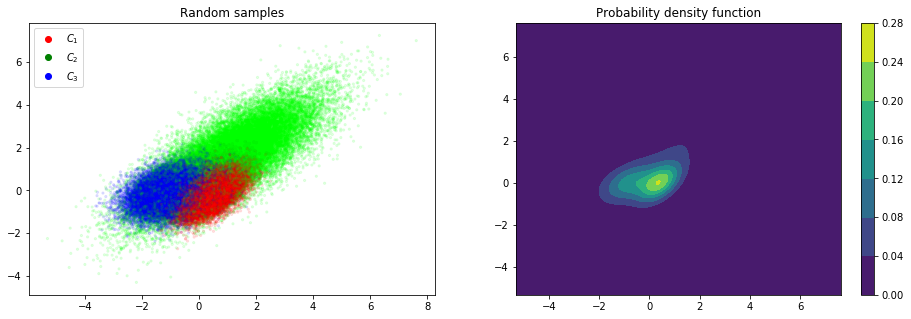

In [4]:
X, Y_bin = mg.sample(n_samples)
Y = np.argmax(Y_bin, axis=1)

x_grid = np.linspace(X.min(), X.max(), grid_levels)
y_grid = np.linspace(X.min(), X.max(), grid_levels)

X_val, Y_bin_val = mg.sample(n_samples)
Y_val = np.argmax(Y_bin_val, axis=1)

X_test, Y_bin_test = mg.sample(n_samples)
Y_test = np.argmax(Y_bin_test, axis=1)

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.set_title('Random samples')
ax1.scatter(X[:,0], X[:,1], s=5, color=Y_bin, alpha=0.1)

c1_mark = mlines.Line2D([], [], color='red', marker='o', linestyle='None', label=r'$C_1$')
c2_mark = mlines.Line2D([], [], color='green', marker='o', linestyle='None', label=r'$C_2$')
c3_mark = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', label=r'$C_3$')

ax1.legend(handles=[c1_mark, c2_mark, c3_mark])

xx, yy = np.meshgrid(x_grid, y_grid)
z = mg.pdf(np.vstack([xx.flatten(), yy.flatten()]).T)

ax2 = fig.add_subplot(122)
ax2.set_title('Probability density function')
contour = ax2.contourf(xx, yy, z.reshape(grid_levels,grid_levels))
fig.colorbar(contour)

## 1.b. Individual probability density functions

[-5.31448931 -5.24950629 -5.18452328 ...  7.48716447  7.55214749
  7.6171305 ]
[-5.31448931 -5.31448931 -5.31448931 ...  7.6171305   7.6171305
  7.6171305 ]
Gaussian(mean = [0.43452381 0.        ], cov = [[0.29883497 0.18132296]
 [0.18132296 0.36264591]])
[-5.31448931 -5.24950629 -5.18452328 ...  7.48716447  7.55214749
  7.6171305 ]
[-5.31448931 -5.31448931 -5.31448931 ...  7.6171305   7.6171305
  7.6171305 ]
Gaussian(mean = [1.  1.5], cov = [[2.28986813 1.64493407]
 [1.64493407 2.03986813]])
[-5.31448931 -5.24950629 -5.18452328 ...  7.48716447  7.55214749
  7.6171305 ]
[-5.31448931 -5.31448931 -5.31448931 ...  7.6171305   7.6171305
  7.6171305 ]
Gaussian(mean = [-0.78333333  0.        ], cov = [[0.57625702 0.18132296]
 [0.18132296 0.36264591]])


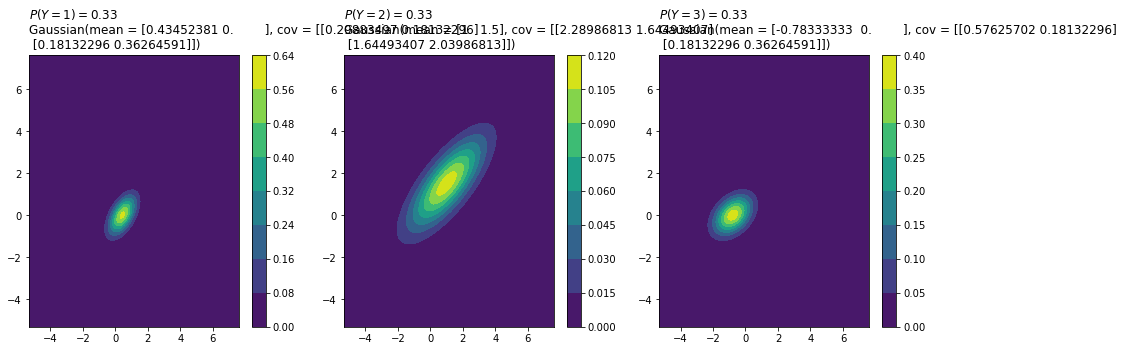

In [5]:
plot_individual_pdfs(mg, x_grid=x_grid, y_grid=y_grid)

## 1.c. Individual posterior probabilities

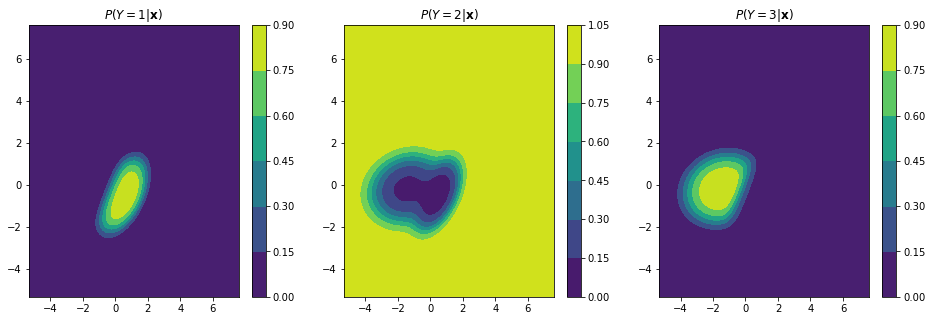

In [6]:
fig = plt.figure()
xx, yy = np.meshgrid(x_grid, y_grid)

Z = mg.posterior(np.vstack([xx.flatten(), yy.flatten()]).T)
    
for i in [0, 1, 2]: 
    ax = fig.add_subplot(1, 3, i+1)
    
    ax.set_title('$P(Y={}|\mathbf{{x}})$'.format(i+1))

    contour = ax.contourf(xx, yy, Z[:,i].reshape(grid_levels,grid_levels))
    fig.colorbar(contour)

# Softmax of Gaussians

## 2.a. Samples of each Class after Softmax

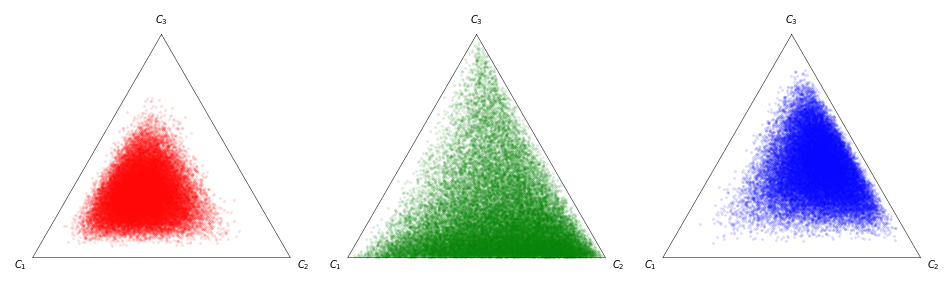

In [7]:
class Softmax(object):
    def __init__(self):
        pass
    
    def fit(self, *args):
        pass
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
        
    def predict_proba(self, X):
        softmax = lambda z:np.divide(np.exp(z).T, np.sum(np.exp(z), axis=1)).T
        return softmax(np.hstack((X, np.zeros((X.shape[0], 1)))))

sm = Softmax()
softmax_outputs = sm.predict_proba(X)

fig = plt.figure(figsize=(16, 5))
for i in [0, 1, 2]:
    ax = fig.add_subplot(1, 3, i+1)

    draw_tri_samples(softmax_outputs[Y == i], colors[i],
                     s=15,
                     marker='.', alpha=0.1, fig=fig, ax=ax)

## 2.b. Scores from Softmax

Softmax Brier score = 1.805e-01
Softmax Log-loss score = 8.870e-01


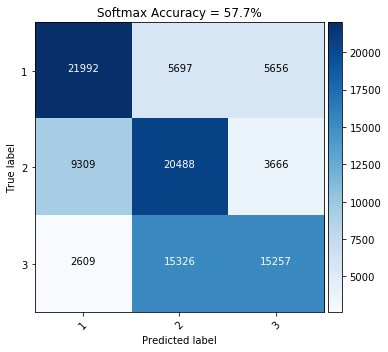

In [8]:
softmax_outputs_test = sm.predict_proba(X_test)

method = 'Softmax'
predictions = softmax_outputs_test

print("{} Brier score = {:.3e}".format(method, mean_squared_error(Y_bin_test, predictions)))  

print("{} Log-loss score = {:.3e}".format(method, log_loss(Y_bin_test, predictions)))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
cm = confusion_matrix(Y_test, np.argmax(predictions, axis=1))

plot_confusion_matrix(cm, classes=['1', '2', '3'], fig=fig, ax=ax,
                      title="{} Accuracy = {:.1f}%".format(method, (Y_test == np.argmax(predictions, axis=1)).mean()*100))

## 2.a. Individual predicted posterior probabilities

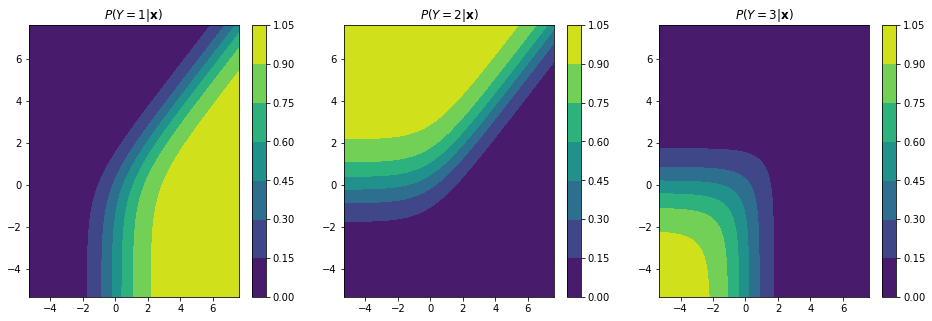

In [9]:
fig = plt.figure()
xx, yy = np.meshgrid(x_grid, y_grid)

Z = sm.predict_proba(np.vstack([xx.flatten(), yy.flatten()]).T)

for i in [0, 1, 2]: 
    ax = fig.add_subplot(1, 3, i+1)
    
    ax.set_title('$P(Y={}|\mathbf{{x}})$'.format(i+1))

    contour = ax.contourf(xx, yy, Z[:,i].reshape(grid_levels,grid_levels))
    fig.colorbar(contour)

## 2.b. Histogram of predicted probabilities for each Actual class

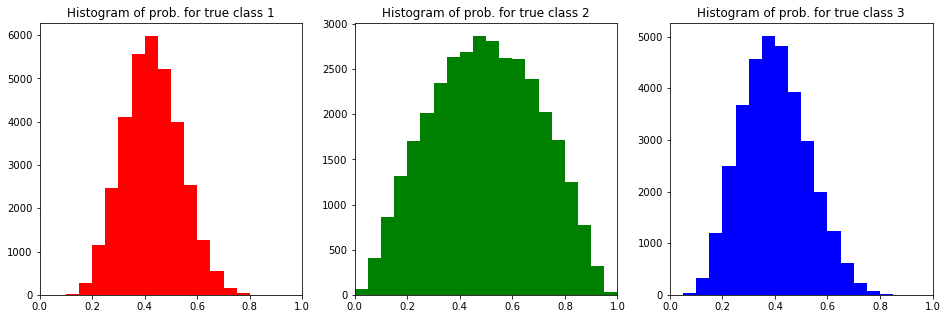

In [10]:
P_nb_test = sm.predict_proba(X_test)

fig = plt.figure()

for i in [0, 1, 2]:
    ax = fig.add_subplot(1, 3, i+1)
    ax.set_title('Histogram of prob. for true class {}'.format(i+1))
    ax.hist(P_nb_test[Y_test == i, i], bins=20, range=(0, 1), color=colors[i])
    ax.set_xlim(0, 1)

## 2.c. 2D Histogram of paired predicted probabilities for each Actual class

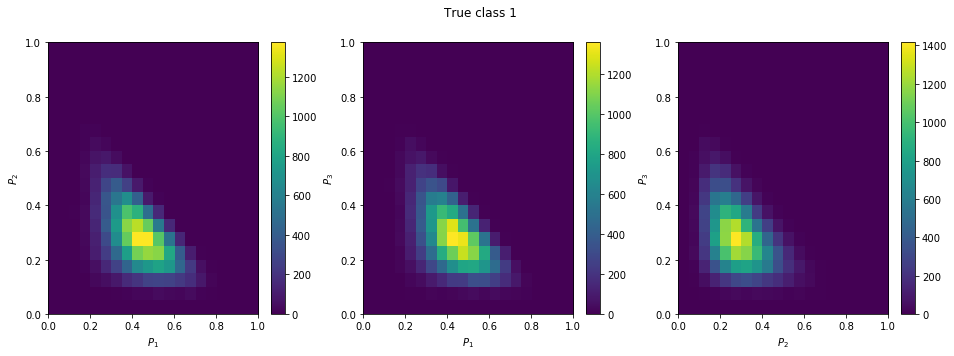

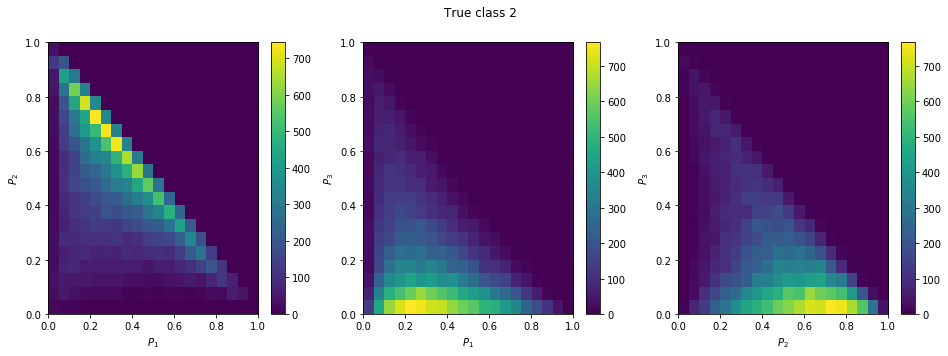

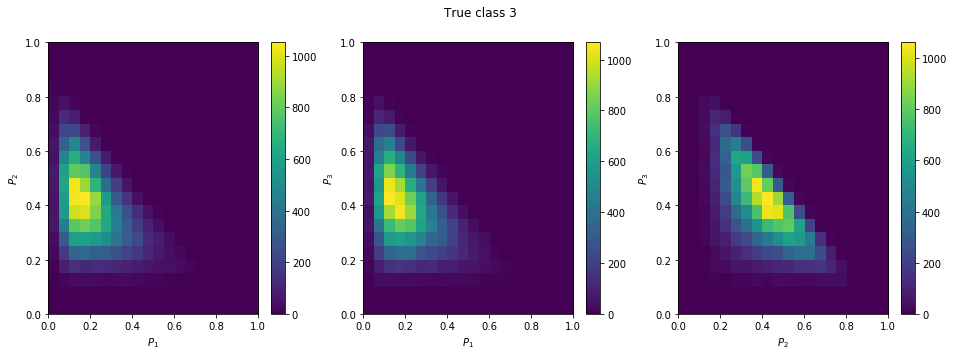

In [11]:
from itertools import combinations

for true_class in [0, 1, 2]:
    fig = plt.figure()
    fig.suptitle('True class {}'.format(true_class+1))
    for i, (cx, cy) in enumerate(combinations([0, 1, 2], 2)):
        ax = fig.add_subplot(1, 3, i+1)
        im = ax.hist2d(P_nb_test[Y_test == true_class, cx], P_nb_test[Y_test == true_class, cy],
                  bins=20, range=[[0, 1], [0, 1]])
        fig.colorbar(im[3], ax=ax)
        ax.set_xlabel(r'$P_{}$'.format(cx+1))
        ax.set_ylabel(r'$P_{}$'.format(cy+1))

## 2.d. Predicted probabilities for each sample

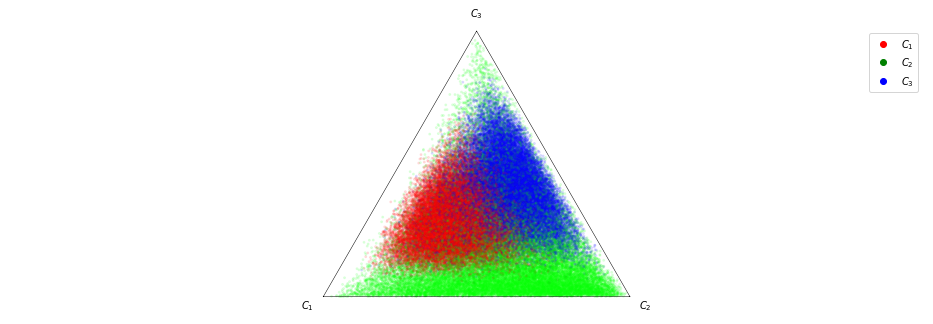

In [12]:
from utils.barycentric import draw_tri_samples

draw_tri_samples(P_nb_test, Y_bin_test, s=15, marker='.', alpha=0.1, handles=[c1_mark, c2_mark, c3_mark])

# 3. Calibration with Multinomial Logistic Regression in log scores

In [13]:
P_nb = sm.predict_proba(X)
P_nb_val = sm.predict_proba(X_val)
P_nb_test = sm.predict_proba(X_test)

perfect_posterior_test = perfect_calibration(X_test, mg)
true_posterior_test = mg.posterior(X_test)

Calibrator parameters
{
  "solver": "lbfgs",
  "random_state": 42,
  "dual": false,
  "penalty": "l2",
  "class_weight": null,
  "n_jobs": null,
  "fit_intercept": true,
  "multi_class": "multinomial",
  "C": 999999.0,
  "warm_start": false,
  "verbose": 0,
  "intercept_scaling": 1,
  "max_iter": 100000,
  "tol": 1e-09
}


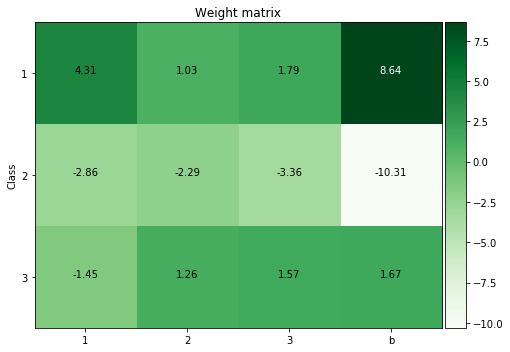

In [14]:
class ScikitDirichletCalibration(object):
    def __init__(self):
        self.lr = LogisticRegression(C=999999.0, solver='lbfgs', multi_class='multinomial',
                           fit_intercept=True, tol=1e-9, random_state=42,
                           max_iter=100000)
        return
        
    def fit(self, X, Y):
        self.lr.fit(np.log(np.clip(X, eps, 1)), Y)
                
        self.coef_ = self.lr.coef_
        self.intercept_ = self.lr.intercept_
        return
    
    def predict_proba(self, X):
        return self.lr.predict_proba(np.log(np.clip(X, eps, 1)))
    
    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)
    
    def get_params(self):
        return self.lr.get_params()

scikitlrcal = ScikitDirichletCalibration()
scikitlrcal.fit(P_nb, Y)


#from sklearn.neural_network import MLPClassifier
#calibrator =  MLPClassifier(solver='lbfgs', alpha=1e-5,
#                            hidden_layer_sizes=(10), random_state=1).fit(log_pred, Y)

print('Calibrator parameters')
import json
print(json.dumps(scikitlrcal.get_params(), indent=2))


scikitlr_P_test = scikitlrcal.predict_proba(P_nb_test)

scikitlr_Y_test = scikitlrcal.predict(P_nb_test)

plot_weight_matrix(scikitlrcal.coef_, scikitlrcal.intercept_, classes=['1', '2', '3'])

Uncalibrated Brier score = 1.805e-01
Scikitlearn LR log Brier score = 1.136e-01
Irreducible Brier score = 1.126e-01

Uncalibrated Log-loss score = 8.870e-01
Scikitlearn LR log Log-loss score = 5.904e-01
Irreducible Log-loss score = 5.822e-01


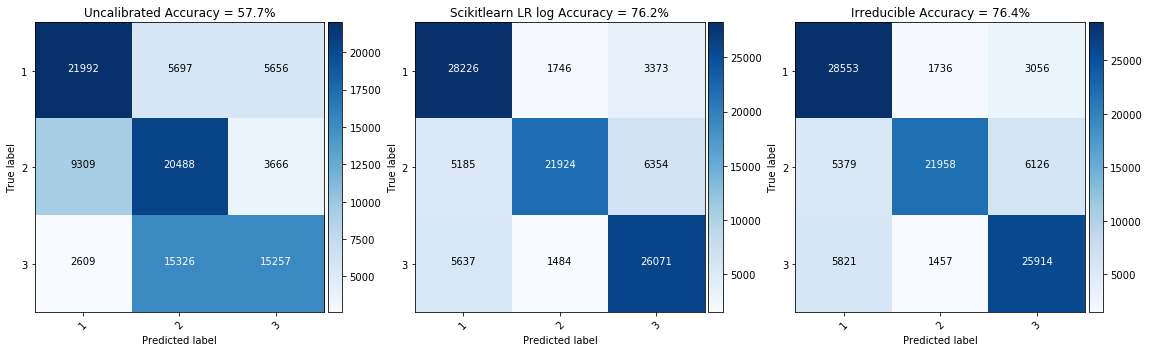

In [15]:
predictions_list = (('Uncalibrated', P_nb_test),
                    ('Scikitlearn LR log', scikitlr_P_test),
                    #('Perfect cal', perfect_posterior_test),
                    ('Irreducible', true_posterior_test))

for i, (method, predictions) in enumerate(predictions_list):
    print("{} Brier score = {:.3e}".format(method, mean_squared_error(Y_bin_test, predictions)))  
    
print()

for i, (method, predictions) in enumerate(predictions_list):
    print("{} Log-loss score = {:.3e}".format(method, log_loss(Y_bin_test, predictions)))

fig = plt.figure()
for i, (method, predictions) in enumerate(predictions_list):  
    ax = fig.add_subplot(1, len(predictions_list), i+1)
    cm = confusion_matrix(Y_test, np.argmax(predictions, axis=1))

    plot_confusion_matrix(cm, classes=['1', '2', '3'], fig=fig, ax=ax,
                          title="{} Accuracy = {:.1f}%".format(method, (Y_test == np.argmax(predictions, axis=1)).mean()*100))

## 3.b. Predicted posteriors

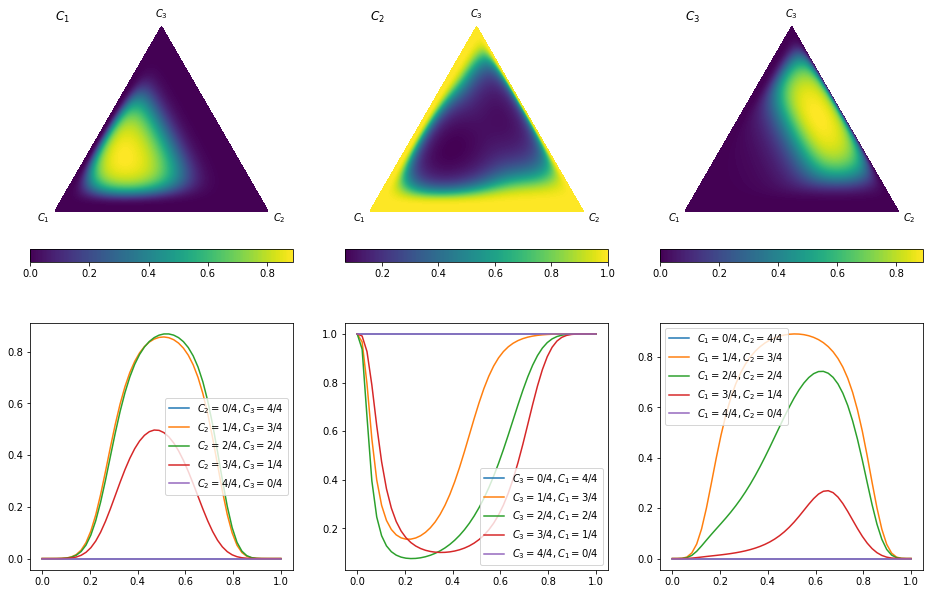

In [16]:
fig = plt.figure(figsize=(16, 10))
for i, c in enumerate(['C1', 'C2', 'C3']):
    ax = fig.add_subplot(2, 3, i+1)
    
    ax.set_title('$C_{}$'.format(i+1), loc='left')
    
    function = lambda x: scikitlrcal.predict_proba(x.reshape(1,-1))[0][i]
    draw_func_contours(function, labels='auto', fig=fig, ax=ax)
    
    ax2 = fig.add_subplot(2, 3, 3+i+1)
    lines = get_converging_lines(num_lines=5, mesh_precision=bc_grid_levels, class_index=i)
    plot_converging_lines_pvalues(function, lines, i, ax2)

# 3.c. Comparison between true posterior and calibrated posterior

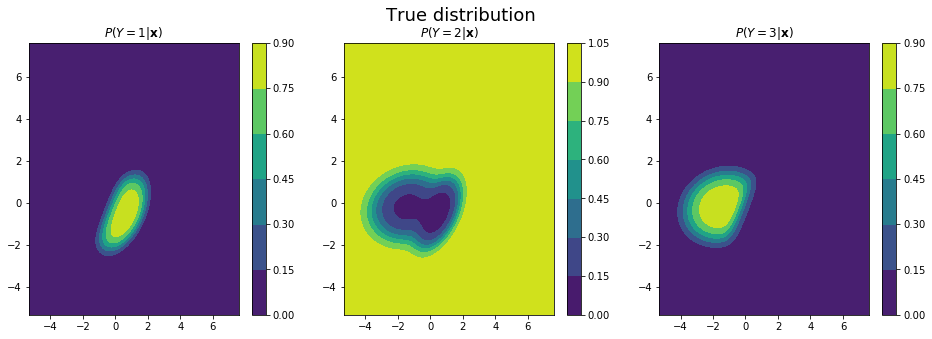

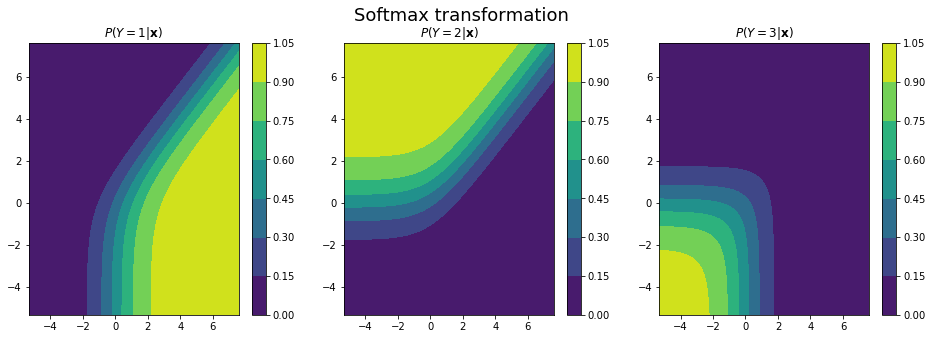

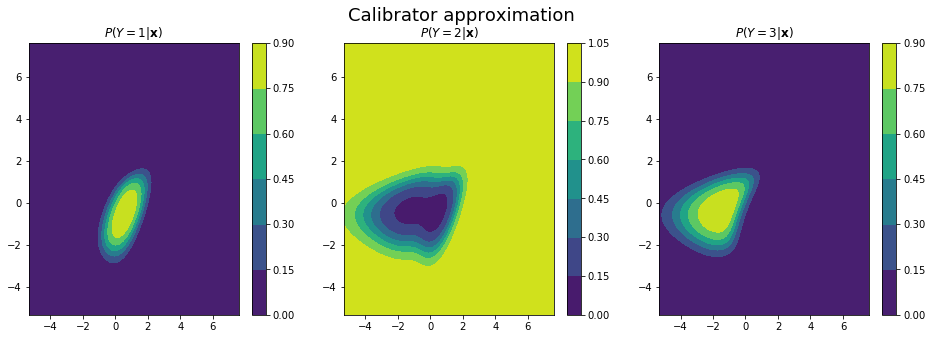

In [17]:
xx, yy = np.meshgrid(x_grid, y_grid)

Z = mg.posterior(np.vstack([xx.flatten(), yy.flatten()]).T)
Z_pred = sm.predict_proba(np.vstack([xx.flatten(), yy.flatten()]).T)
Z_cal_pred = scikitlrcal.predict_proba(Z_pred)

for j, (name, z) in enumerate((('True distribution', Z),
                              ('Softmax transformation', Z_pred),
                              ('Calibrator approximation', Z_cal_pred))):
    fig = plt.figure()
    fig.suptitle(name, fontsize=18)
    for i in [0, 1, 2]: 
        ax = fig.add_subplot(1, 3, i+1)

        ax.set_title('$P(Y={}|\mathbf{{x}})$'.format(i+1))

        contour = ax.contourf(xx, yy, z[:,i].reshape(grid_levels,grid_levels))
        fig.colorbar(contour)

# 4. Calibration with Artificial Neural Network log scores

Calibrator parameters
{
  "solver": "lbfgs",
  "momentum": 0.9,
  "learning_rate_init": 0.001,
  "n_iter_no_change": 10,
  "alpha": 1e-05,
  "power_t": 0.5,
  "activation": "relu",
  "batch_size": "auto",
  "max_iter": 200,
  "learning_rate": "constant",
  "tol": 0.0001,
  "epsilon": 1e-08,
  "random_state": 1,
  "shuffle": true,
  "beta_1": 0.9,
  "beta_2": 0.999,
  "early_stopping": false,
  "validation_fraction": 0.1,
  "hidden_layer_sizes": 10,
  "nesterovs_momentum": true,
  "verbose": false,
  "warm_start": false
}


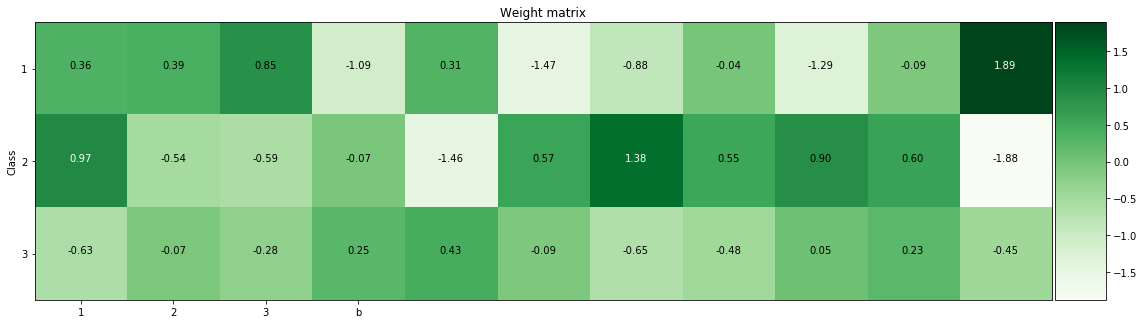

In [18]:
log_P_nb = np.log(np.clip(P_nb, eps, 1))
from sklearn.neural_network import MLPClassifier

class ScikitANNCalibration(object):
    def __init__(self):
        self.calibrator = MLPClassifier(solver='lbfgs', alpha=1e-5,
                                        hidden_layer_sizes=(10), random_state=1)
        return
        
    def fit(self, X, Y):
        self.calibrator.fit(np.log(np.clip(X, eps, 1)), Y)
                
        self.coef_ = self.calibrator.coefs_[-1].T
        self.intercept_ = self.calibrator.intercepts_[-1]
        return
    
    def predict_proba(self, X):
        return self.calibrator.predict_proba(np.log(np.clip(X, eps, 1)))
    
    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)
    
    def get_params(self):
        return self.calibrator.get_params()
    
annlogcal =  ScikitANNCalibration()
annlogcal.fit(P_nb, Y)

print('Calibrator parameters')
import json
print(json.dumps(annlogcal.get_params(), indent=2))

annlogcal_P_test = annlogcal.predict_proba(P_nb_test)

annlogcal_Y_test = annlogcal.predict(P_nb_test)

plot_weight_matrix(annlogcal.coef_, annlogcal.intercept_, classes=['1', '2', '3'])

Uncalibrated Brier score = 1.805e-01
Calibrated ANN Brier score = 1.128e-01
Irreducible Brier score = 1.126e-01

Uncalibrated Log-loss score = 8.870e-01
Calibrated ANN Log-loss score = 5.835e-01
Irreducible Log-loss score = 5.822e-01


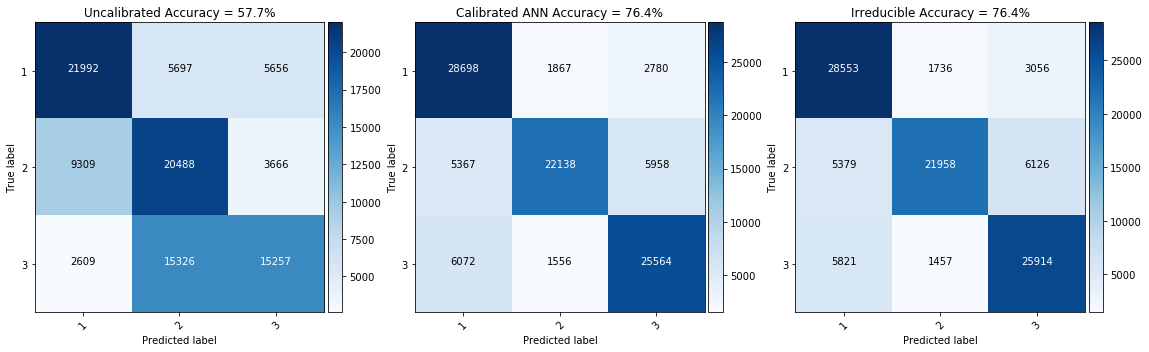

In [19]:
perfect_posterior_test = perfect_calibration(X_test, mg)

true_posterior_test = mg.posterior(X_test)

predictions_list = (('Uncalibrated', P_nb_test),
                    ('Calibrated ANN', annlogcal_P_test),
                    #('Perfect cal', perfect_posterior_test),
                    ('Irreducible', true_posterior_test))

for i, (method, predictions) in enumerate(predictions_list):
    print("{} Brier score = {:.3e}".format(method, mean_squared_error(Y_bin_test, predictions)))  
    
print()

for i, (method, predictions) in enumerate(predictions_list):
    print("{} Log-loss score = {:.3e}".format(method, log_loss(Y_bin_test, predictions)))

fig = plt.figure()
for i, (method, predictions) in enumerate(predictions_list):  
    ax = fig.add_subplot(1, len(predictions_list), i+1)
    cm = confusion_matrix(Y_test, np.argmax(predictions, axis=1))

    plot_confusion_matrix(cm, classes=['1', '2', '3'], fig=fig, ax=ax,
                          title="{} Accuracy = {:.1f}%".format(method, (Y_test == np.argmax(predictions, axis=1)).mean()*100))

## 4.b. Predicted posteriors

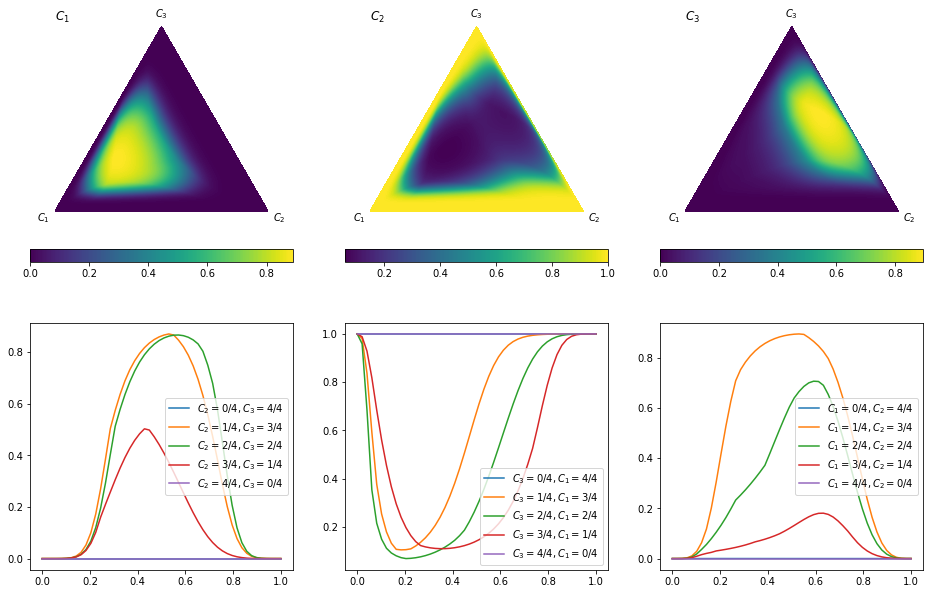

In [20]:
fig = plt.figure(figsize=(16, 10))
for i, c in enumerate(['C1', 'C2', 'C3']):
    ax = fig.add_subplot(2, 3, i+1)
    
    ax.set_title('$C_{}$'.format(i+1), loc='left')
    
    function = lambda x: annlogcal.predict_proba(x.reshape(1,-1))[0][i]
    draw_func_contours(function, labels='auto', fig=fig, ax=ax)
    
    ax2 = fig.add_subplot(2, 3, 3+i+1)
    lines = get_converging_lines(num_lines=5, mesh_precision=bc_grid_levels, class_index=i)
    plot_converging_lines_pvalues(function, lines, i, ax2)

# 4.c. Comparison between true posterior and calibrated posterior

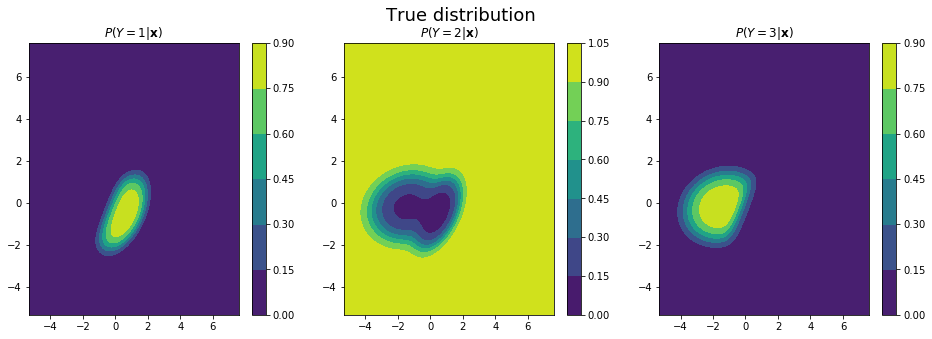

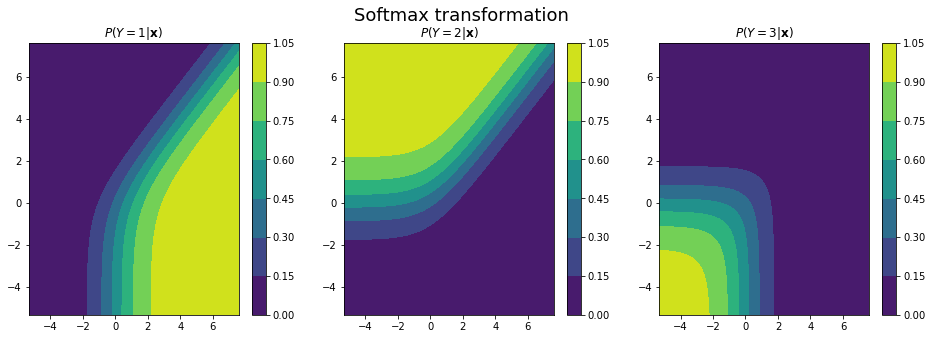

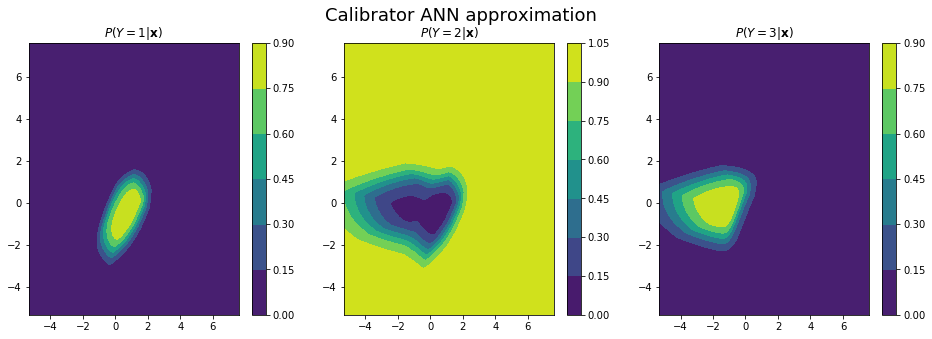

In [21]:
xx, yy = np.meshgrid(x_grid, y_grid)

Z = mg.posterior(np.vstack([xx.flatten(), yy.flatten()]).T)
Z_pred = sm.predict_proba(np.vstack([xx.flatten(), yy.flatten()]).T)
annlogcal_Z_pred = annlogcal.predict_proba(Z_pred)

for j, (name, z) in enumerate((('True distribution', Z),
                              ('Softmax transformation', Z_pred),
                              ('Calibrator ANN approximation', annlogcal_Z_pred))):
    fig = plt.figure()
    fig.suptitle(name, fontsize=18)
    for i in [0, 1, 2]: 
        ax = fig.add_subplot(1, 3, i+1)

        ax.set_title('$P(Y={}|\mathbf{{x}})$'.format(i+1))

        contour = ax.contourf(xx, yy, z[:,i].reshape(grid_levels,grid_levels))
        fig.colorbar(contour)

# 5. Other calibrators

In [22]:
from calib.models.calibration import MAP_CALIBRATORS

# Dirichlet cal
dircal = DirichletCalibrator()
dircal.fit(P_nb, Y)
dircal_P_test = dircal.predict_proba(P_nb_test)

# Width binning
widthbincal = MAP_CALIBRATORS['binning_width']
widthbincal.fit(P_nb, Y, P_nb_val, Y_val)
widthbin_P_test = widthbincal.predict_proba(P_nb_test)

# Freq. binning
freqbincal = MAP_CALIBRATORS['binning_freq']
freqbincal.fit(P_nb, Y, P_nb_val, Y_val)
freqbin_P_test = freqbincal.predict_proba(P_nb_test)

# LR 
lrcal = LogisticRegression(C=999999.0, solver='lbfgs', multi_class='multinomial',
                            fit_intercept=True, tol=1e-9, random_state=42,
                            max_iter=100000).fit(P_nb, Y)

lrcal.fit(P_nb, Y)
lrcal_P_test = lrcal.predict_proba(P_nb_test)

# ANN
anncal =  MLPClassifier(solver='lbfgs', alpha=1e-5,
                        hidden_layer_sizes=(10), random_state=1).fit(P_nb, Y)
anncal_P_test = anncal.predict_proba(P_nb_test)
# ANN log(score)
annlogcal_P_test = annlogcal.predict_proba(P_nb_test)

calibrators_list = (('Freq. binning cal', freqbincal),
                    ('Width binning cal', widthbincal),
                    ('LR', lrcal),
                    ('LR log', scikitlrcal),
                    ('Dirichlet cal', dircal),
                    ('ANN cal', anncal),
                    ('ANN log cal', annlogcal))

Using Theano backend.


## 5.b. Performance of all calibrators

In [23]:
true_posterior_test = mg.posterior(X_test)

predictions_list = (('Uncalibrated', P_nb_test),
                    ('Freq. binning cal', freqbin_P_test),
                    ('Width. binning cal', widthbin_P_test),
                    ('LR cal', lrcal_P_test),
                    ('Scikit LR log cal', scikitlr_P_test),
                    ('Dirichlet cal', dircal_P_test),
                    ('ANN cal', anncal_P_test),
                    ('ANN log cal', annlogcal_P_test),
                    ('Irreducible', true_posterior_test))


for i, (method, predictions) in enumerate(predictions_list):
    print("{} Accuracy = {:.1f}%".format(method, (Y_test == np.argmax(predictions, axis=1)).mean()*100))
print()    
for i, (method, predictions) in enumerate(predictions_list):
    print("{} Brier score = {:.3e}".format(method, mean_squared_error(Y_bin_test, predictions)))  
    
print()
for i, (method, predictions) in enumerate(predictions_list):
    print("{} Log-loss score = {:.3e}".format(method, log_loss(Y_bin_test, predictions)))


Uncalibrated Accuracy = 57.7%
Freq. binning cal Accuracy = 63.3%
Width. binning cal Accuracy = 64.3%
LR cal Accuracy = 71.4%
Scikit LR log cal Accuracy = 76.2%
Dirichlet cal Accuracy = 76.2%
ANN cal Accuracy = 75.8%
ANN log cal Accuracy = 76.4%
Irreducible Accuracy = 76.4%

Uncalibrated Brier score = 1.805e-01
Freq. binning cal Brier score = 1.600e-01
Width. binning cal Brier score = 1.585e-01
LR cal Brier score = 1.366e-01
Scikit LR log cal Brier score = 1.136e-01
Dirichlet cal Brier score = 1.136e-01
ANN cal Brier score = 1.167e-01
ANN log cal Brier score = 1.128e-01
Irreducible Brier score = 1.126e-01

Uncalibrated Log-loss score = 8.870e-01
Freq. binning cal Log-loss score = 7.698e-01
Width. binning cal Log-loss score = 7.644e-01
LR cal Log-loss score = 7.467e-01
Scikit LR log cal Log-loss score = 5.904e-01
Dirichlet cal Log-loss score = 5.904e-01
ANN cal Log-loss score = 6.051e-01
ANN log cal Log-loss score = 5.835e-01
Irreducible Log-loss score = 5.822e-01


## 5.c. Posterior probabilities in the Simplex for all calibrators

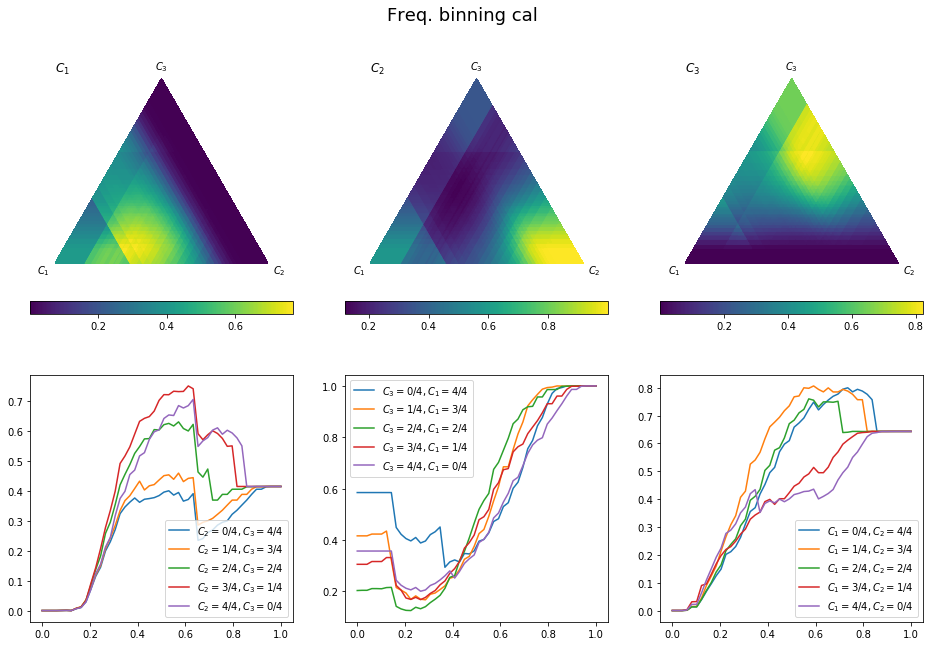

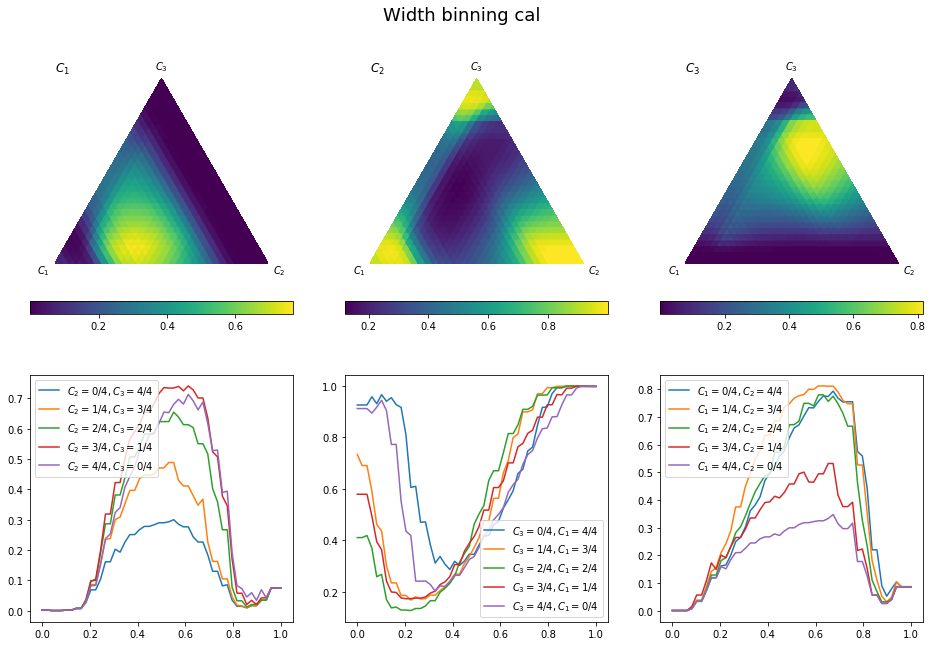

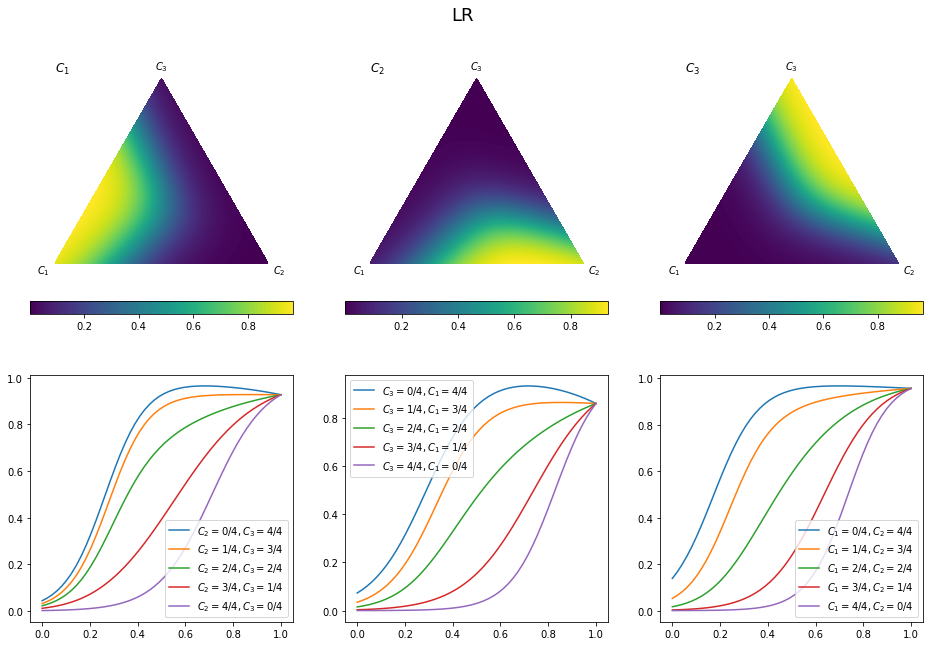

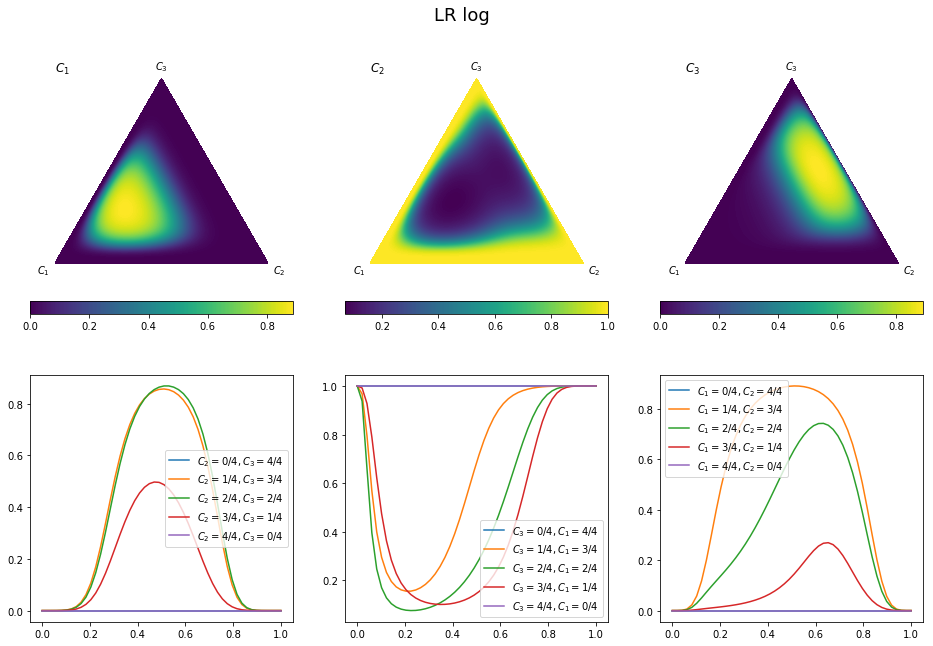

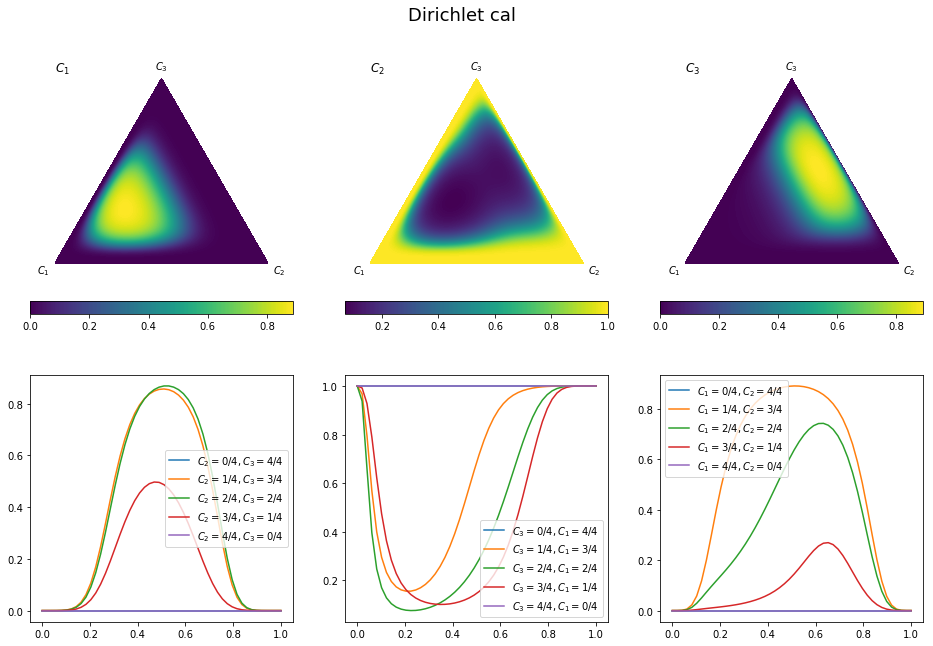

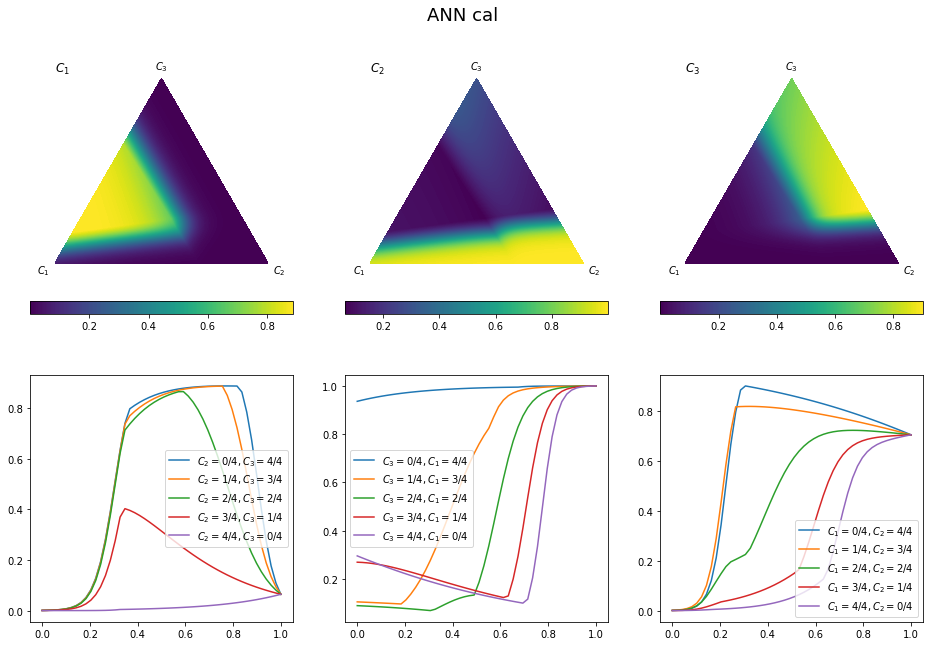

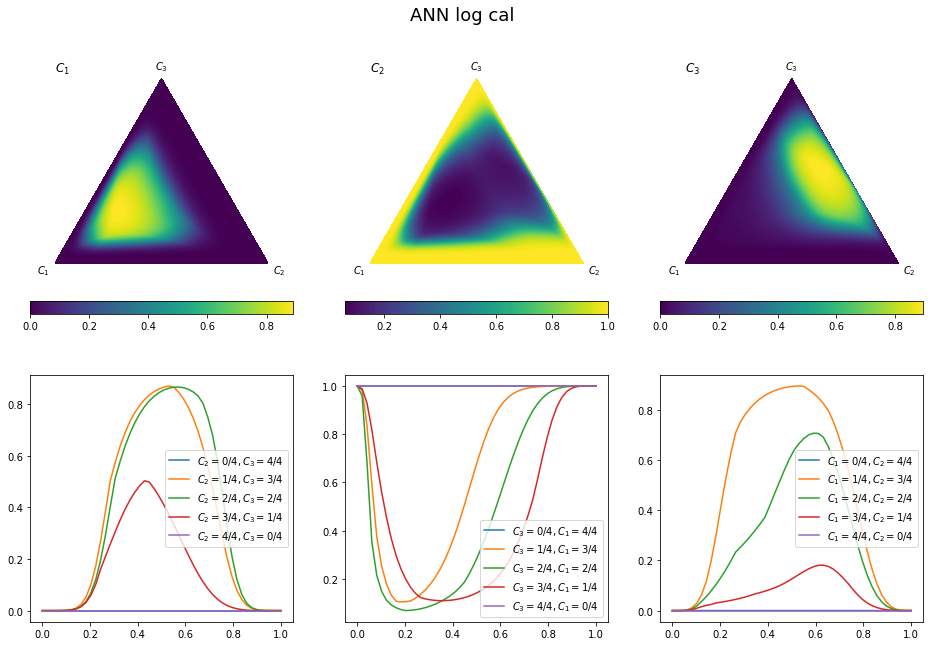

In [24]:
for j, (cal_name, calibrator) in enumerate(calibrators_list):
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle(cal_name, fontsize=18)
    for i, c in enumerate(['C1', 'C2', 'C3']):
        ax = fig.add_subplot(2, 3, i+1)
        ax.set_title('$C_{}$'.format(i+1), loc='left')

        function = lambda x: calibrator.predict_proba(x.reshape(1,-1))[0][i]
        draw_func_contours(function, labels='auto', fig=fig, ax=ax)

        ax2 = fig.add_subplot(2, 3, i+4)
        lines = get_converging_lines(num_lines=5, mesh_precision=bc_grid_levels, class_index=i)
        plot_converging_lines_pvalues(function, lines, i, ax2)

## 5.d. Posterior probabilities in original feature space

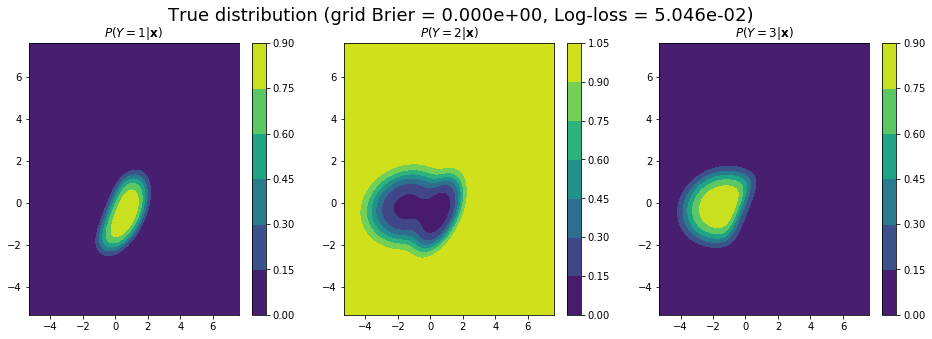

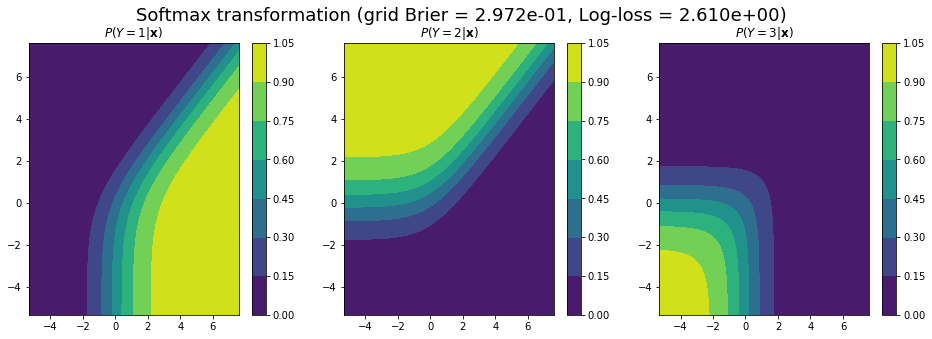

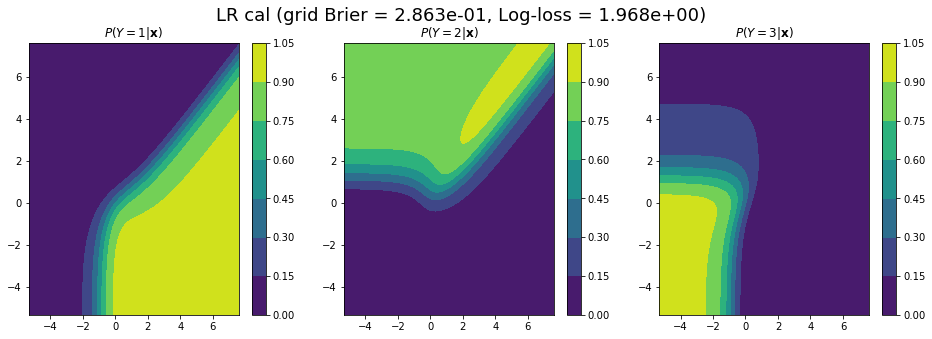

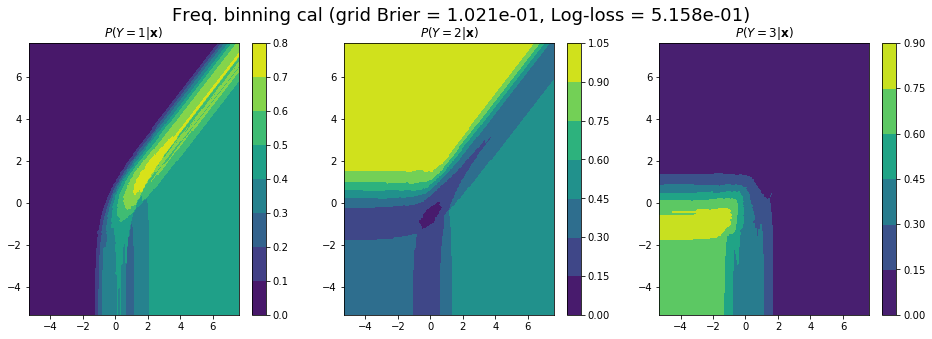

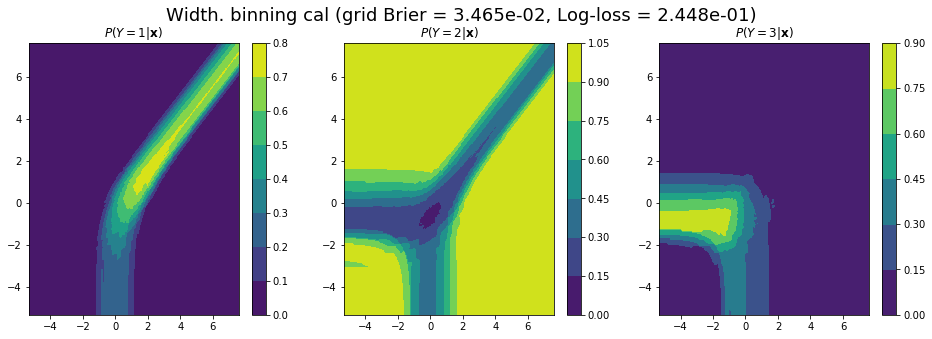

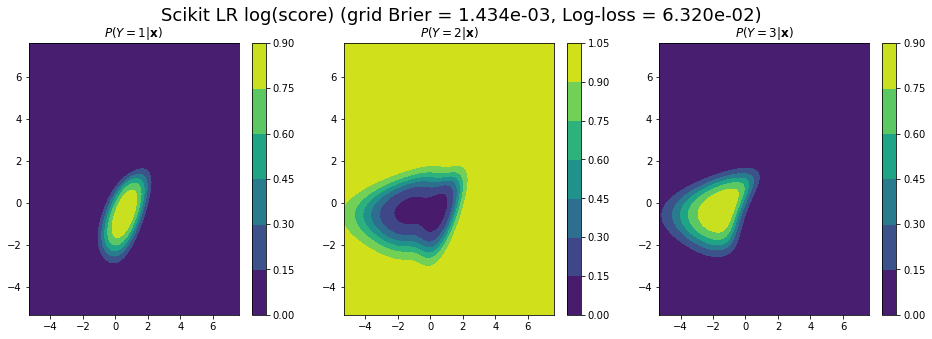

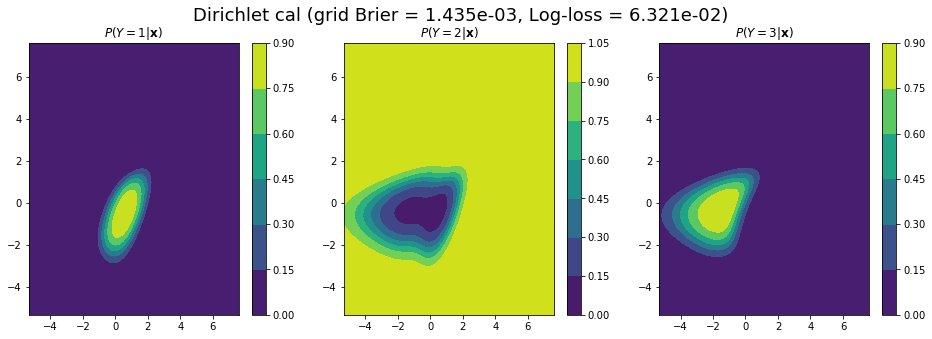

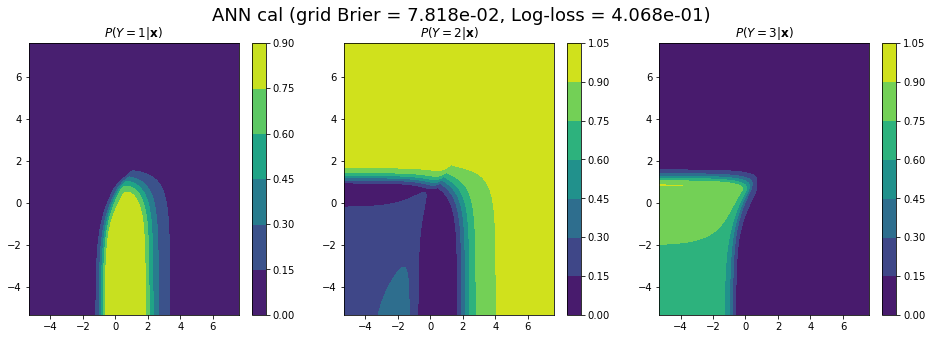

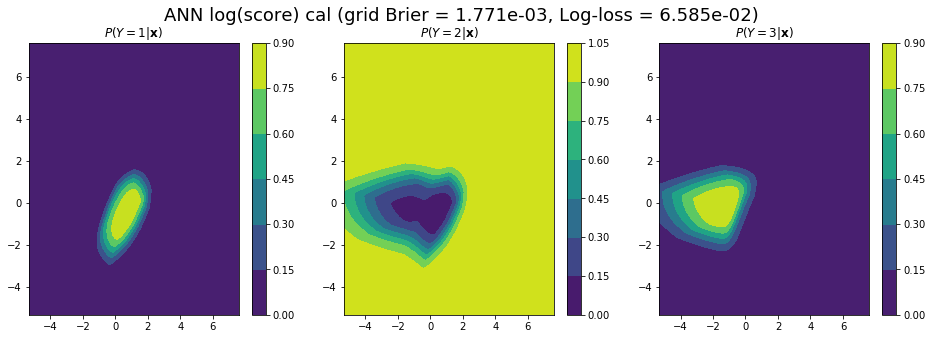

In [25]:
xx, yy = np.meshgrid(x_grid, y_grid)

P_grid = mg.posterior(np.vstack([xx.flatten(), yy.flatten()]).T)
softmax_P_grid = sm.predict_proba(np.vstack([xx.flatten(), yy.flatten()]).T)

# Scikit LR log
scikitlr_P_grid = scikitlrcal.predict_proba(softmax_P_grid)
# Dirichlet cal
dircal_P_grid = dircal.predict_proba(softmax_P_grid)
# Width binning
widthbin_P_grid = widthbincal.predict_proba(softmax_P_grid)
# Freq. binning
freqbin_P_grid = freqbincal.predict_proba(softmax_P_grid)
# LR 
lrcal_P_grid = lrcal.predict_proba(softmax_P_grid)
# ANN
anncal_P_grid = anncal.predict_proba(softmax_P_grid)
# ANN log(score)
annlogcal_P_grid = annlogcal.predict_proba(softmax_P_grid)

P_grid_list = (('True distribution', P_grid),
              ('Softmax transformation', softmax_P_grid),
              ('LR cal', lrcal_P_grid),
              ('Freq. binning cal', freqbin_P_grid),
              ('Width. binning cal', widthbin_P_grid),
              ('Scikit LR log(score)', scikitlr_P_grid),
              ('Dirichlet cal', dircal_P_grid),
              ('ANN cal', anncal_P_grid),
              ('ANN log(score) cal', annlogcal_P_grid))

for j, (name, z) in enumerate(P_grid_list):
    fig = plt.figure()

    fig.suptitle("{} (grid Brier = {:.3e}, Log-loss = {:.3e})".format(name,
                                                               mean_squared_error(P_grid, z),
                                                               log_loss(P_grid.argmax(axis=1), z)),
                 fontsize=18)
    
    for i in [0, 1, 2]: 
        ax = fig.add_subplot(1, 3, i+1)

        ax.set_title('$P(Y={}|\mathbf{{x}})$'.format(i+1))

        contour = ax.contourf(xx, yy, z[:,i].reshape(grid_levels,grid_levels))
        fig.colorbar(contour)

## 5.d. Performance in full grid of original space

**IMPORTANT**

- Brier score is computed with the original posterior probabilities and predicted by the calibrators
- Log-loss is computed with the **argmax of the original posterior probabilties** and the predicted by the calibrators

In [26]:
  for i, (method, predictions) in enumerate(P_grid_list):
    print("{} Brier score = {:.3e}".format(method, mean_squared_error(P_grid, predictions)))  
    
print()
for i, (method, predictions) in enumerate(P_grid_list):
    print("{} Log-loss score = {:.3e}".format(method, log_loss(P_grid.argmax(axis=1), predictions)))

True distribution Brier score = 0.000e+00
Softmax transformation Brier score = 2.972e-01
LR cal Brier score = 2.863e-01
Freq. binning cal Brier score = 1.021e-01
Width. binning cal Brier score = 3.465e-02
Scikit LR log(score) Brier score = 1.434e-03
Dirichlet cal Brier score = 1.435e-03
ANN cal Brier score = 7.818e-02
ANN log(score) cal Brier score = 1.771e-03

True distribution Log-loss score = 5.046e-02
Softmax transformation Log-loss score = 2.610e+00
LR cal Log-loss score = 1.968e+00
Freq. binning cal Log-loss score = 5.158e-01
Width. binning cal Log-loss score = 2.448e-01
Scikit LR log(score) Log-loss score = 6.320e-02
Dirichlet cal Log-loss score = 6.321e-02
ANN cal Log-loss score = 4.068e-01
ANN log(score) cal Log-loss score = 6.585e-02
